### Statistical Analysis of Generated Data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob
%matplotlib widget

#### Data distribution

In [3]:
# Histograms of data

oh = pd.read_excel('descriptors_OH.xlsx').dropna()
mace_averaged_oh = oh.groupby(['Cas']).mean()
fig, ax = plt.subplots(5,3)
descriptors = mace_averaged_oh.columns

descriptor_count = 0
for i in range(5):
    for j in range(3):
        
        ax[i, j].hist(x = mace_averaged_oh[descriptors[descriptor_count]], bins='auto', density=True)
        ax[i, j].set_ylabel(descriptors[descriptor_count])
        descriptor_count+=1
        


NameError: name 'pd' is not defined

#### MLR on selected data points

In [15]:
from sklearn.linear_model import LinearRegression
from pandas import read_excel
import numpy as np


def MLR(X, y):
    # data = read_excel('PCA.xlsx')
    # X = np.array([list(data['steric']),  list(data['elec']), list(data['geom'])]).T
    # y = list(data['yield'])

    reg = LinearRegression().fit(X, y)

    print('R2 = ', reg.score(X,y))

    # print('coef: ', reg.coef_, 'intercept:', reg.intercept_)
    return reg.score(X,y)


#### PCA

In [6]:
from sklearn.decomposition import PCA
from umap import UMAP
import itertools

data = mace_averaged_oh
geom_keys = ['bite_angle']
steric_keys = ['dipole', 'sasa','buried_volume']
elec_keys = ['HOMO_LUMO_gap', 'dispersion', 'ea','nucleofugality', 'electrofugality', 'electrophilicity', 'nucleophilicity']

pca1 = PCA(n_components=1)
pca2 = PCA(n_components=1)
pca3 = PCA(n_components=3)

u_geom = pca1.fit_transform(data[geom_keys]) 
u_steric = pca2.fit_transform(data[steric_keys])
u_elec = pca3.fit_transform(data[elec_keys])


data['Cas'] = data.index
dataframe = pd.DataFrame()

descriptor_order = 1

dataframe['steric1'] = u_steric[:, 0]
# dataframe['steric2'] = u_steric[:, 1]
dataframe['elec1'] = u_elec[:, 0]
dataframe['elec2'] = u_elec[:, 1]
dataframe['elec3'] = u_elec[:, 2]
dataframe['geom'] = u_geom[:, 0]

### Add second order interactions
for comb in itertools.combinations(['steric1', 'elec1','elec2','elec3', 'geom' ], 2):
    dataframe["_".join(comb)] = dataframe[comb[0]] * dataframe[comb[1]]

# for index, key1 in enumerate(dataframe.keys()):
#     for key2 in dataframe.keys()[index:]:
#         dataframe[key1 + '_' + key2] = dataframe[key1]*dataframe[key2] 

dataframe['yield'] = data['yield'].to_list()
dataframe['ee'] = data['ee'].to_list()

dataframe['Cas'] = data['Cas'].to_list()
dataframe['label_yield'] = pd.cut(x = dataframe['yield'], bins=[0, 0.8, 1],
                     labels=[0, 1])

dataframe.to_excel('PCA3_good_substrate_.xlsx')

# X = np.array([list(dataframe['steric1']),list(dataframe['steric2']), list(dataframe['elec1']),  list(dataframe['elec2']), list(dataframe['elec3']), list(dataframe['geom'])])
# print(X)
# X2 = X**2
# X3 = X**3

X = dataframe.drop(['Cas', 'yield', 'label_yield', 'ee'], axis=1)
# X = np.array([X, X2, X3])
y = dataframe ['yield']
# X = list(dataframe['elec1'])
# y = list(dataframe['elec3'])

MLR(X, y)

R2 =  0.4919220927964312


(array([-3.02964845e-04,  4.61060150e-02,  5.21415794e-02, -6.33837502e-02,
        -6.95400166e-04,  9.87684985e-05, -3.98531479e-05,  7.20884123e-04,
        -3.90553565e-04,  9.80019101e-03, -7.89194267e-02,  1.53752488e-02,
         1.51952322e-02,  1.92565912e-02,  6.79951791e-02]),
 0.5444890437012695)

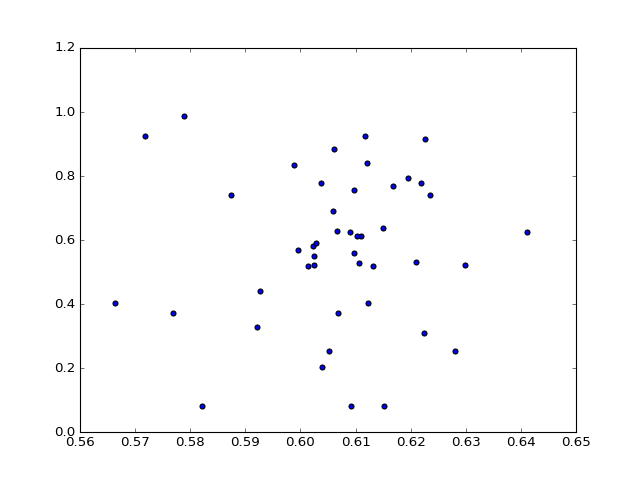

In [ ]:
plt.close('all')
plt.scatter(mace_averaged_oh['buried_volume'], mace_averaged_oh['yield'])
plt.show()

# Function for confidence intervals

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


arr = np.linspace(0, 50, 100).reshape((10, 10))

fig, ax = plt.subplots(ncols=2)

cmap = plt.get_cmap('twilight')
new_cmap = truncate_colormap(cmap, 0.2, 0.8)
ax[0].imshow(arr, interpolation='nearest', cmap=cmap)
ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
# plt.show()
plt.close('all')

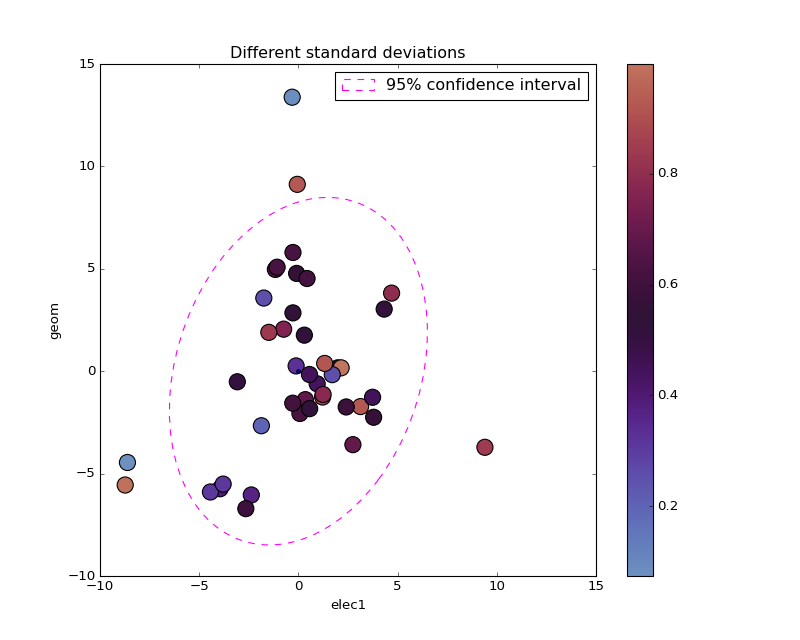

In [13]:
fig, ax_nstd = plt.subplots(figsize=(10, 8))
plt.style.use('classic')
plt.rcParams['image.cmap'] = new_cmap

p1 = 'elec1'
p2 = 'geom'
heat_map = 'yield'
### Change all ferrocenes
x = dataframe[p1] 
y = dataframe[p2] 

mu = np.average(x), np.average(y)

sc = ax_nstd.scatter(x, y, c=mace_averaged_oh[heat_map], s=210)
fig.colorbar(sc)

# 1365531-98-1

# confidence_ellipse(x, y, ax_nstd, n_std=1,
#     label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
    label=r'95% confidence interval', edgecolor='fuchsia', linestyle='--')

# confidence_ellipse(x, y, ax_nstd, n_std=3,
#     label=r'$3\sigma$', edgecolor='blue', linestyle=':')


annot = ax_nstd.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
names = list(dataframe['Cas'])

def update_annot(ind):
    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    # annot.get_bbox_patch().set_facecolor(cmap(np.linalg.norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)

def hover(event):
    vis = annot.get_visible()
    try:
        if event.inaxes == ax_nstd:
            cont, ind = sc.contains(event)
            if cont:
                print(annot, end=" "*50 + '\r')
                update_annot(ind)
                annot.set_visible(True)
                fig.canvas.draw_idle()
            else:
                if vis:
                    annot.set_visible(False)
                    fig.canvas.draw_idle()
    except Exception:
        pass
    
fig.canvas.mpl_connect("motion_notify_event", hover)

ax_nstd.scatter(mu[0], mu[1], s=10)
ax_nstd.set_title('Different standard deviations')
ax_nstd.set_xlabel(p1)
ax_nstd.set_ylabel(p2)
fig.set_facecolor('white')
ax_nstd.legend()

plt.savefig("std_{}_{}_heatmap_{}.png".format(p1, p2, heat_map), dpi=400, bbox_inches='tight')
plt.show()  

## Multinomial Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


df = pd.read_excel('PCA3_good_substrate_.xlsx')

X = df.drop(['yield', 'Cas', 'label_yield', 'ee'], axis=1)

y = df['label_yield']

random_states = 30
store = []
for random_state in range(random_states):
    X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                    random_state=random_state, 
                                    test_size=0.25, 
                                    shuffle=True)
    lr = LogisticRegression(max_iter=1800)
    lr.fit(X_train, y_train)
    preds = lr.predict(X_test)
    prob = preds==y_test

    store.append(np.average(prob))

print('size=', len(X_test))
print('avg =', np.average(store), np.max(store), np.argmax(store))
# print(np.average(prob))
# a = pd.DataFrame(preds)
# a.to_excel('preds.xlsx')



c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

size= 12
avg = 0.7499999999999999 0.9166666666666666 12


c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## MLR

In [11]:
random_states = 10
store = []
for random_state in range(random_states):
    X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                    random_state=random_state, 
                                    test_size=0.25, 
                                    shuffle=True)
    
    model = LinearRegression()
    reg  = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print('R2 = ', reg.score(X_test, y_test))

R2 =  -0.3718967620301816
R2 =  -10.672314227706954
R2 =  -1.271021384290508
R2 =  -0.683284849851405
R2 =  -2.8737866241720704
R2 =  -2.068139234139578
R2 =  -0.64078082805617
R2 =  0.0
R2 =  -1.9693058569611006
R2 =  -1.9326956407807505


### ExtraTreesClassifier

In [36]:
from sklearn.ensemble import ExtraTreesClassifier
plt.style.use('classic')
TOP_FEATURES = 7
X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                random_state=42, 
                                test_size=0.25, 
                                shuffle=True)

# model = LinearRegression()
# reg  = model.fit(X_train, y_train)

forest = ExtraTreesClassifier(n_estimators=700, max_depth=10, random_state=15)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in forest.estimators_],
    axis=0
)
indices = np.argsort(importances)[::-1]
indices = indices[:TOP_FEATURES]

print('Top features:')
for f in range(TOP_FEATURES):
    print('%d. feature %d (%f)' % (f + 1, indices[f], importances[indices[f]]))
    
fig = plt.figure()
plt.title('Top feature importances')
plt.bar(
    range(TOP_FEATURES), 
    importances[indices],
    yerr=std[indices], 
)
plt.xticks(range(TOP_FEATURES), X_train.keys()._data[indices])
fig.set_facecolor('white')
plt.show()
print(X_train.keys())
plt.savefig('feature_ranking.png')

ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Stacking classifier

In [17]:
from mlxtend.classifier import StackingClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
import random

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                random_state=random.randrange(100), 
                                test_size=0.25, 
                                shuffle=True)


m = StackingClassifier(
    classifiers=[
        LogisticRegression(max_iter=5000),
        XGBClassifier(max_depth=10)
    ],
    use_probas=True,
    meta_classifier=LogisticRegression()
)

m = m.fit(X_train,y_train)
print(m.predict(X_test), y_test, 'R2', m.score(X_test,y_test))


[0 0 0 0 0 0 1 0 0 0 0 0] 4     1
35    0
22    0
26    1
43    1
28    0
20    0
15    0
6     1
34    0
16    0
40    0
Name: label_yield, dtype: int64 R2 0.5833333333333334


### Random forest

In [18]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                random_state=random.randrange(100), 
                                test_size=0.25, 
                                shuffle=True)
regr = RandomForestRegressor(max_depth=2, random_state=random.randrange(100))
regr = regr.fit(X_train, y_train)

print(list(np.abs(np.array(y_test) - np.array(regr.predict(X_test)))/np.array(y_test) * 100))

[inf, inf, inf, inf, inf, inf, 62.626890322218465, inf, inf, inf, 96.10971242764926, inf]


C:\Users\Adrian\AppData\Local\Temp\ipykernel_13140\2316680048.py:9: RuntimeWarning: divide by zero encountered in divide
  print(list(np.abs(np.array(y_test) - np.array(regr.predict(X_test)))/np.array(y_test) * 100))


### 3D Plot


0.43478260869565216


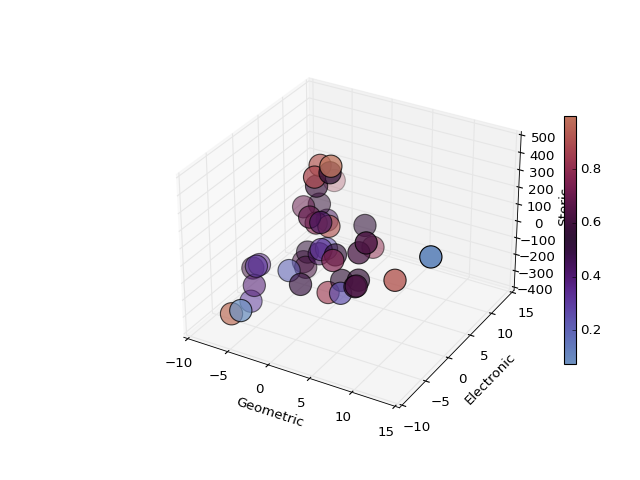

In [115]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
oh = pd.read_excel('descriptors_OH.xlsx').dropna()
dataframe =oh.groupby(['Cas']).mean()

u_geom = pca.fit_transform(dataframe[geom_keys]) 
u_steric = pca.fit_transform(dataframe[steric_keys])
u_elec = pca.fit_transform(dataframe[elec_keys])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Gen colors 
# reds = np.zeros((len(df['yield']), 3))
# for i in range(len(df['yield'])):
#     reds[i,:] = [df['yield'][i],  df['yield'][i]/10, df['yield'][i]/10]

plt.rcParams['image.cmap'] = new_cmap
print(max(np.abs(dataframe['ee'])))
p = ax.scatter(u_geom, u_elec, u_steric, c=np.abs(dataframe['yield']), s=400)
ax.set_xlabel('Geometric') # geom effects
ax.set_ylabel('Electronic') 
ax.set_zlabel('Steric')
fig.colorbar(p, fraction=0.025, pad=0.05)
fig.set_facecolor('white')
fig.savefig('3D_PCA.png', dpi=300, bbox_inches='tight')

## Ir-P bonds MLR


In [33]:
# Pkg
import pandas as pd
import numpy as np

# Import data from distances

data = pd.read_excel('distances.xlsx')
# print(data)
data = data[data['yield'] > 0.32]
X = data.drop(['yield'], axis=1)
y = data['yield']

# Skeleton bond ->> (2.34603586872537, 2.401789943590405)
skeleton_bond = (2.34603586872537, 2.401789943590405)
MLR(X, y)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [85]:

from morfeus import read_xyz
from numpy.linalg import norm
import os, glob
import numpy as np
import pandas as pd


def find_distance(xyz):
    elements, coordinates = read_xyz(xyz)
    P_coord = []
    for ind_element, element in enumerate(elements):
        if element == 'P':
            P_coord.append(ind_element)
        if element == 'Ir':
            ind_Ir = ind_element

    d1 = norm(coordinates[ind_Ir]  - coordinates[P_coord[0]])
    d2 = norm(coordinates[ind_Ir]  - coordinates[P_coord[1]])

    return d1, d2

find_distance('xtbopt.xyz')

(2.289163867135348, 2.4193144899290635)

R2 =  0.5252908965304564
Cas
133545-25-2      0.778351
1365531-89-0     0.582418
1365531-98-1     0.082682
136705-62-9      0.987425
136705-64-1      0.923537
137219-86-4      0.519318
139139-86-9      0.924636
1429939-35-4     0.522883
145214-59-1      0.739469
147253-67-6      0.401837
155806-35-2      0.558651
155830-69-6      0.770000
158923-09-2      0.625988
158923-11-6      0.251807
167416-28-6      0.638403
184095-69-0      0.329496
185913-97-7      0.628037
187733-50-2      0.757169
192138-05-9      0.528675
192463-40-4      0.308693
210169-40-7      0.401837
210169-54-3      0.778351
210169-57-6      0.550836
223120-71-6      0.530303
246231-79-8      0.794244
256390-47-3      0.883323
292638-88-1      0.841063
301847-89-2      0.522883
325168-89-6      0.739469
352655-61-9      0.202911
360048-63-1      0.612316
394248-45-4      0.590154
528565-79-9      0.372155
528854-34-4      0.567286
55739-58-7       0.082682
64896-28-2       0.372155
849924-41-0      0.833601
849924-45

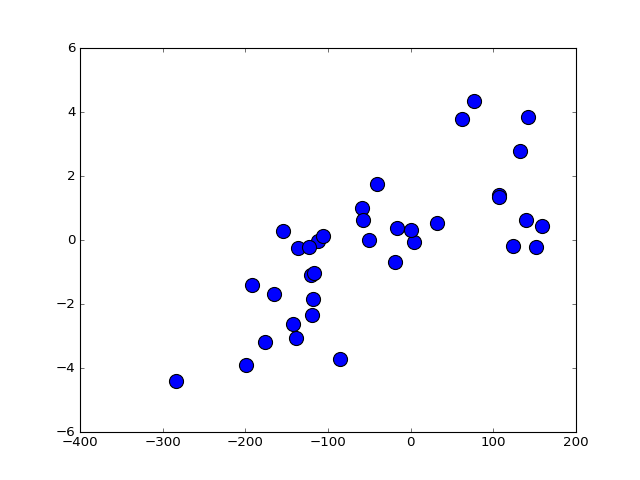

In [77]:
plt.figure()
y =  mace_averaged_oh[heat_map]
X = X[(X['elec1'] > -5) & (X['elec1'] < 4.6) & (X['steric1']<280)] 
p = plt.scatter(X['steric1'], X['elec1'], s=160)
MLR(np.array(X['steric1']).reshape(-1,1), X['elec1'])

print(y)
# fig.colorbar()


plt.show()

### Sigman dataset

In [21]:
### Find correlation between the yield column and all others.

dataframe_sigman = pd.read_excel('JNJ_AH_Sigman_descriptors_CLEAN.xlsx').dropna()
features = dataframe_sigman.drop(['JNJ Entry #', 'JNJ alias', 'CAS', 'Yield', 'Formula', 'Class','Sigman Ligand ID', 'Sigman ligand name'], axis = 1)
y = dataframe_sigman['Yield']
R2s = []
for i in range(len(features)):
    try:
        plt.figure()
        plt.scatter(features[features.columns[i]], y)
        plt.savefig('presentation_images/{}.png'.format(features.columns[i]))
        
        R2 = MLR(np.array(features[features.columns[i]]).reshape(-1,1), y)
        R2s.append(R2)
        print(features.columns[i])
        plt.close('all')
    except Exception:   
        plt.close('all')


print(np.argmax(np.array(R2s)))

R2 =  0.006008237018772289
R1_NBO_min
R2 =  0.006132627235025834
R1_NBO_max
R2 =  0.006073984436631763
R1_NBO_avg
R2 =  0.0018745452377942895
R2_NBO_min
R2 =  0.0017734902178414558
R2_NBO_max
R2 =  0.0018252973383846571
R2_NBO_avg
R2 =  0.05327313779753462
RBack1_NBO_min
R2 =  0.05778557576144694
RBack1_NBO_max
R2 =  0.05549935262886685
RBack1_NBO_avg
R2 =  0.006913382355062669
R3_NBO_min
R2 =  0.007016510973876344
R3_NBO_max
R2 =  0.006973655211928165
R3_NBO_avg
R2 =  0.0006655480549043746
R4_NBO_min
R2 =  0.0006072980004420137
R4_NBO_max
R2 =  0.0006364790391302222
R4_NBO_avg
R2 =  0.024148430025104806
RBack2_NBO_min
R2 =  0.026708429556087543
RBack2_NBO_max
R2 =  0.025410928436275904
RBack2_NBO_avg
R2 =  0.01938149832526659
P1_NMR_min
R2 =  0.03941622783014387
P1_NMR_max
R2 =  0.028744875495746558
P1_NMR_avg
R2 =  0.00012983836171309715
P2_NMR_min
R2 =  0.0012842337228444745
P2_NMR_max
R2 =  0.00016489654342410898
P2_NMR_avg
R2 =  5.28130676080707e-07
aniso_P1_NMR_min
R2 =  0.000792

In [24]:
MLR(np.array(features[features.columns[52]]).reshape(-1,1), y)


R2 =  0.05821262681757233


0.05821262681757233

0.05821262681757233